In [38]:
import tensorflow as tf
# to share the GPU resources for multiple sessions
from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True # dynamically grow the memory used on the GPU
config.log_device_placement = True # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)


Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GRID A100D-40C, pci bus id: 0000:02:02.0, compute capability: 8.0



2024-05-10 07:46:45.535871: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-10 07:46:45.536068: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-10 07:46:45.536171: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [40]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import utils
from tensorflow.keras import models
from sklearn.metrics import classification_report,confusion_matrix
%matplotlib inline


In [42]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [44]:
my_data_dir='dataset/cell_images'

In [46]:
os.listdir(my_data_dir)

['test', 'train']

In [48]:
test_path=my_data_dir+'/test/'
train_path=my_data_dir+'/train'

In [50]:
os.listdir(train_path)

['parasitized', 'uninfected']

In [52]:
len(os.listdir(train_path+'/uninfected/'))

12479

In [54]:
len(os.listdir(train_path+'/parasitized/'))

12479

In [126]:
os.listdir(train_path+'/parasitized')[0]

'C182P143NThinF_IMG_20151201_172257_cell_157.png'

In [58]:
para_img= imread(train_path+
                 '/parasitized/'+
                 os.listdir(train_path+'/parasitized')[0])

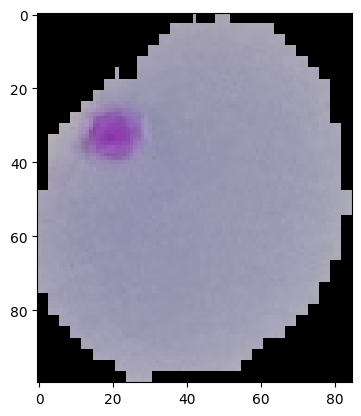

In [60]:
plt.imshow(para_img)

In [62]:
dim1 = []
dim2 = []
for image_filename in os.listdir(test_path+'/uninfected'):
    img = imread(test_path+'/uninfected'+'/'+image_filename)
    d1,d2,colors = img.shape
    dim1.append(d1)
    dim2.append(d2)

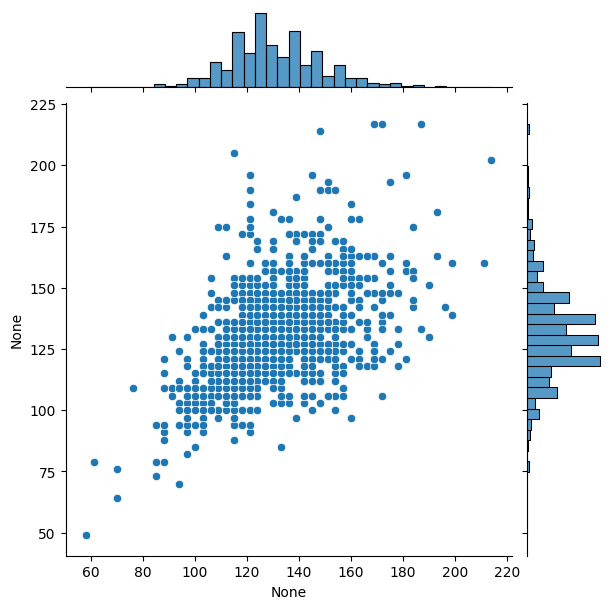

In [64]:
sns.jointplot(x=dim1,y=dim2)

In [66]:
image_shape = (130,130,3)

In [68]:
help(ImageDataGenerator)

Help on class ImageDataGenerator in module keras.src.preprocessing.image:

class ImageDataGenerator(builtins.object)
 |  ImageDataGenerator(featurewise_center=False, samplewise_center=False, featurewise_std_normalization=False, samplewise_std_normalization=False, zca_whitening=False, zca_epsilon=1e-06, rotation_range=0, width_shift_range=0.0, height_shift_range=0.0, brightness_range=None, shear_range=0.0, zoom_range=0.0, channel_shift_range=0.0, fill_mode='nearest', cval=0.0, horizontal_flip=False, vertical_flip=False, rescale=None, preprocessing_function=None, data_format=None, validation_split=0.0, interpolation_order=1, dtype=None)
 |  
 |  Generate batches of tensor image data with real-time data augmentation.
 |  
 |  Deprecated: `tf.keras.preprocessing.image.ImageDataGenerator` is not
 |  recommended for new code. Prefer loading images with
 |  `tf.keras.utils.image_dataset_from_directory` and transforming the output
 |  `tf.data.Dataset` with preprocessing layers. For more infor

In [70]:
image_gen = ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               width_shift_range=0.10, # Shift the pic width by a max of 5%
                               height_shift_range=0.10, # Shift the pic height by a max of 5%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 10% max
                               horizontal_flip=True, # Allo horizontal flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )

In [72]:
image_gen.flow_from_directory(train_path)

Found 24958 images belonging to 2 classes.


In [74]:
image_gen.flow_from_directory(test_path)

Found 2600 images belonging to 2 classes.


In [76]:
model = models.Sequential()
model.add(layers.Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(filters=32, kernel_size=(5,5), activation='relu',))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu',))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))


model.add(layers.Flatten())

model.add(layers.Dense(128))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))


model.add(layers.Dense(64))
model.add(layers.Activation('relu'))

model.add(layers.Dense(1))
model.add(layers.Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [78]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 64, 64, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 60, 60, 32)        51232     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 30, 30, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 14, 14, 16)       

In [80]:
batch_size = 16

In [82]:
help(image_gen.flow_from_directory)

Help on method flow_from_directory in module keras.src.preprocessing.image:

flow_from_directory(directory, target_size=(256, 256), color_mode='rgb', classes=None, class_mode='categorical', batch_size=32, shuffle=True, seed=None, save_to_dir=None, save_prefix='', save_format='png', follow_links=False, subset=None, interpolation='nearest', keep_aspect_ratio=False) method of keras.src.preprocessing.image.ImageDataGenerator instance
    Takes the path to a directory & generates batches of augmented data.
    
    Args:
        directory: string, path to the target directory. It should contain
          one subdirectory per class. Any PNG, JPG, BMP, PPM or TIF images
          inside each of the subdirectories directory tree will be included
          in the generator. See [this script](
          https://gist.github.com/fchollet/0830affa1f7f19fd47b06d4cf89ed44d)
          for more details.
        target_size: Tuple of integers `(height, width)`, defaults to `(256,
          256)`. The di

In [84]:
train_image_gen = image_gen.flow_from_directory(train_path,
                                               target_size=image_shape[:2],
                                                color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary')

Found 24958 images belonging to 2 classes.


In [86]:
train_image_gen.batch_size

16

In [88]:
len(train_image_gen.classes)

24958

In [90]:
train_image_gen.total_batches_seen

0

In [92]:
test_image_gen = image_gen.flow_from_directory(test_path,
                                               target_size=image_shape[:2],
                                               color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary',shuffle=False)

Found 2600 images belonging to 2 classes.


In [94]:
train_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

In [96]:
results = model.fit(train_image_gen,epochs=2,
                              validation_data=test_image_gen
                             )

Epoch 1/2
1560/1560 [==============================] - 110s 69ms/step - loss: 0.4900 - accuracy: 0.7255 - val_loss: 0.2063 - val_accuracy: 0.9388
Epoch 2/2
1560/1560 [==============================] - 108s 69ms/step - loss: 0.1765 - accuracy: 0.9455 - val_loss: 0.1711 - val_accuracy: 0.9473


In [98]:
model.save('cell_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [100]:
losses = pd.DataFrame(model.history.history)

POOJASREE B
 212223040148


<Axes: >

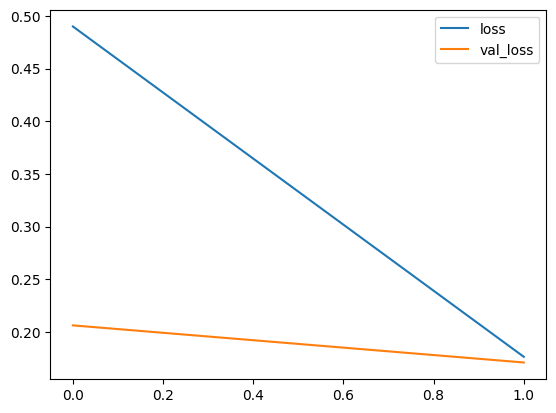

In [102]:
print("POOJASREE B\n 212223040148")
losses[['loss','val_loss']].plot()

In [104]:
model.metrics_names

['loss', 'accuracy']

In [106]:
model.evaluate(test_image_gen)

163/163 [==============================] - 10s 61ms/step - loss: 0.1703 - accuracy: 0.9473


[0.17031355202198029, 0.9473077058792114]

In [108]:
pred_probabilities = model.predict(test_image_gen)

163/163 [==============================] - 10s 62ms/step


In [110]:
test_image_gen.classes

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [112]:
predictions = pred_probabilities > 0.5

In [114]:
print("POOJASREE B\n212223040148")
print(classification_report(test_image_gen.classes,predictions))

POOJASREE B
212223040148
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1300
           1       0.94      0.96      0.95      1300

    accuracy                           0.95      2600
   macro avg       0.95      0.95      0.95      2600
weighted avg       0.95      0.95      0.95      2600



In [116]:
print("POOJASREE B\n212223040148")
confusion_matrix(test_image_gen.classes,predictions)

POOJASREE B
212223040148


array([[1218,   82],
       [  50, 1250]])

In [118]:
import random
import tensorflow as tf
list_dir=["uninfected"]
dir_=(random.choice(list_dir))
para_img= imread(train_path+
                 '/'+dir_+'/'+
                 os.listdir(train_path+'/'+dir_)[random.randint(0,100)])

In [120]:
img  = tf.convert_to_tensor(np.asarray(para_img))
img = tf.image.resize(img,(130,130))

In [122]:

img=img.numpy()
pred=bool(model.predict(img.reshape(1,130,130,3))<0.5 )

1/1 [==============================] - 0s 105ms/step


POOJASREE B
212223040148


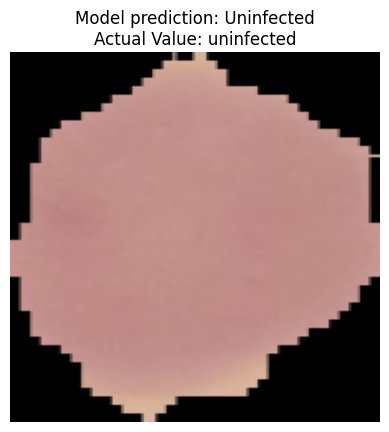

In [244]:
print("POOJASREE B\n212223040148")
plt.title("Model prediction: "+("Parasitized" if pred  else "Uninfected")+"\nActual Value: "+str(dir_))
plt.axis("off")
plt.imshow(img)
plt.show()
